<a href="https://colab.research.google.com/github/simonians/PracticoN3-RedesNeuronales-AutoencoderFeedForward/blob/main/Autoencoder_Feed_Forward_Terminado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/mnist') 

Mounted at /mnist


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets as datasets
from torch import nn

Torchvision.datasets ya tiene incorporado al dataset de MNIST. Con el modulo datasets.MNIST lo incorporamos a nuestro código. Lo vamos a guardar en nuestro drive en una carpeta llamada ./data. 
Con train=true le estamos diciendo que nos descargue el conjunto de entrenamiento xq MNIST ya tiene hecha la división entre entrenamiento y testeo, y despues lo descargamos. Con transforms.Compose permitimos transformar nuestro dataset, haciendo primero una transformacion en un tensor de torch y luego normalizandolo (restamos media y dividimos x la varianza (son media y varianza de los píxeles) que se la proveemos nosotros, para tener una distribucion con media cero y varianza 1). 


In [ ]:
mnist_data = datasets.MNIST('./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Ahora vamos a usar el data set de test, por eso hacemos train=False. Como no conocemos nada del dataset de test, lo normalizamos x la media y varianza del conjunto de entrenamiento.

In [ ]:
mnist_test = datasets.MNIST('./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

Vamos a pasarle los parámetros de entrenamiento. 

In [ ]:
n_epochs = 100 #donde una época se da cuando le pasamos todo el conjunto de entramiento completo al modelo
batch_size_train = 1000 #el minibatch es no pasarle los datos online ni todo el conjunto de datos en batch, sino pasarle de a pequeños pedacitos de batch. En este caso le vamos a pasar 64 imágenes y con esas 64 imágenes el modelo me va calcular la función de costos y corregir los valores de los parámetros
batch_size_test = 1000 #como en el test no estoy entrenando por lo q podría pasarle todo el dataset de una, pero dada la capacidad de google de computo le paso 1000
learning_rate = 0.001 #cuanto me voy a mover en la direccion del gradiente calculado
momentum = 0.5 #es la correcion 
log_interval = 10 #esta es una variable para printear, le digo a la red printeame cada 10 valores

random_seed = 1 #fijo la semilla de torch que es un numerito para el que le digo al generador de numeros aleatorios que me ponga siempre los mismos numeros aleatorios en los mismos lugares, es decir que el modelo se inicialice siempre igual 
torch.manual_seed(random_seed)

Para analizar los valores del learning rate y momentum podemos hacer una busqueda en grilla, pero moviendonos sobre lo que dice el estado del arte. Para learning rate 10^-1, 10^-2, 10^-3 es lo más usado. Mientras que para el momentum entre 0.5 y 0.9

Generamos los Dataloaders de entrenamiento y test, los mismos son iteradores creados sobre los conjuntos de datos de entrenamiento y test, que agrupan los datos en los batch, mezclan los datos si es necesario (con shuffle = true), etc.


In [ ]:
train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size_test)

Definimos una operación que, dada una imagen, la "aplana", generandome un vector a partir de la imagen. Esto me hace perder informacion, es decir al tener neuronas lineales pierdo la informacion x ej de la cercanía de los parámetros. 

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Creamos el autoencoder para enseñar la identidad

In [ ]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.drop = nn.Dropout(0.1)
        self.linear2 = nn.Linear(512, 784)
        self.relu = nn.ReLU()
        self.flatten = Flatten()
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.drop(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x) #¿Hay q aplicar relu o no en la capa de salida?
        return x

In [ ]:
autoenc = autoencoder()
optimizer = torch.optim.Adam(autoenc.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = torch.optim.RMSprop(autoenc.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(autoenc.parameters(), lr=10)

In [ ]:
flatten = Flatten()

In [ ]:
train_losses = []
train_losses_drop = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
    autoenc.train()
    train_loss_drop = 0
    crossent = nn.MSELoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = autoenc(data)
        loss = crossent(output, flatten(data))
        train_loss_drop += loss.detach().item()
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    train_loss_drop /= len(train_loader)
    train_losses_drop.append(train_loss_drop)

In [ ]:
def test():
    crossent = nn.MSELoss()
    autoenc.eval()
    test_loss = 0
    train_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = autoenc(data)
            test_loss += crossent(output, flatten(data)).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        for data, target in train_loader:
            output = autoenc(data)
            train_loss += crossent(output, flatten(data)).item()
    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    train_losses.append(train_loss)
    print('\nTest set: Avg. loss: {:.4f}, train loss: {} '.format(
        test_loss, train_loss, len(test_loader.dataset)))

In [ ]:
test()
for epoch in range(1, 19 + 1):
    train(epoch)
    test()


Test set: Avg. loss: 1.0379, train loss: 1.0233129382133483 
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.023102
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.627596
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.483060
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.401913
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.363349
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.326973

Test set: Avg. loss: 0.2816, train loss: 0.285541732609272 
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.307850
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.293980
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.280510
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.271401
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.268739
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.262517

Test set: Avg. loss: 0.2368, train loss: 0.23957694818576178 
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.256342
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.252050
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.252055
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.250150
Train Epoch: 3 [40000/60000 (

In [ ]:
print(train_losses) "train_losses es un array con los average de test y del train "

[1.0233129382133483, 0.285541732609272, 0.23957694818576178, 0.22691820661226908, 0.2207131008307139, 0.2168519154191017, 0.2144155556956927, 0.21242308815320332, 0.2109979341427485, 0.2097204275429249, 0.20914018402496973, 0.20831065128246942, 0.20764591718713443, 0.20651225447654725, 0.20592516536513963, 0.20535298436880112, 0.2047993761797746, 0.20425622090697287, 0.20418672064940135, 0.20379667257269224]


Usamos como optimization function ADAM y guardamos el error en una función llamada test_lossesADAM, para despúes poder graficarlo con la RMSprop

In [ ]:
test_lossesADAM = test_losses

Ahora usamos como optimization function RMSprop y guardamos el error en una función llamada test_lossesRMSprop. De esta forma vamos a poder plotear ambos errores de testeo juntos y ver cuál conviene seguir usando

In [ ]:
test_lossesRMSprop = test_losses

también se incorporará en el gráfico una tercera línea que representará el error de testeo con SGD

In [ ]:
test_lossesSGD = test_losses

Graficamos ambos en un mismo gráfico para analizar comportamientos: 

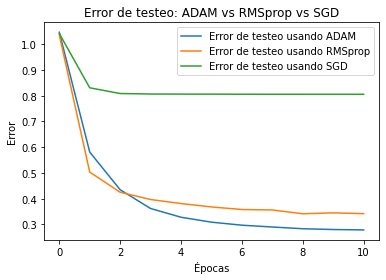

In [ ]:
fig, ax = plt.subplots()
ax.plot(test_lossesADAM,label='Error de testeo usando ADAM')
ax.plot(test_lossesRMSprop,label='Error de testeo usando RMSprop')
ax.plot(test_lossesSGD,label='Error de testeo usando SGD')
ax.set_title("Error de testeo: ADAM vs RMSprop vs SGD")
ax.set_xlabel('Épocas')  
ax.set_ylabel('Error')
ax.legend()


Text(0.5, 0, 'Epochs')

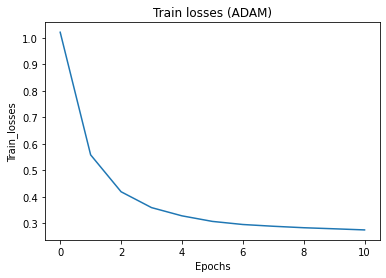

In [ ]:
plt.plot(train_losses)
plt.title("Train losses (ADAM)")
plt.ylabel('Train_losses')
plt.xlabel('Epochs')

Text(0.5, 0, 'Train Epoch')

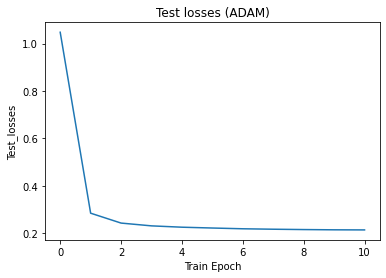

In [ ]:
plt.plot(test_losses)
plt.title("Test losses (ADAM)")
plt.ylabel('Test_losses')
plt.xlabel('Train Epoch')

A continuación tenemos que hacer 2 gráficos donde se junte la red con 64, 128, 256 y 512 neuronas en la capa oculta y ver cómo mejora el proceso de aprendizaje. 

Capa de 64 neuronas:

In [ ]:
test_losses64 = test_losses
train_losses64 = train_losses

Capa de 128 neuronas: 

In [ ]:
test_losses128 = test_losses
train_losses128 = train_losses

capa de 256 neuronas: 

In [ ]:
test_losses256 = test_losses
train_losses256 = train_losses 

capa de 512 neuronas

In [ ]:
test_losses512 = test_losses
train_losses512 = train_losses 

Todas las capas en un sólo gráfico. Primero se verá el error de entrenamiento de las mismas y luego el de testeo: 

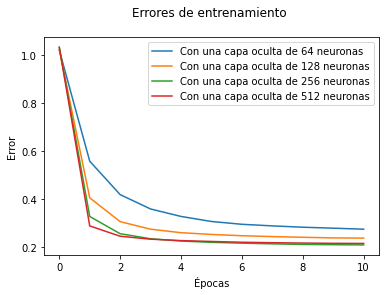

In [ ]:
fig, ax = plt.subplots()
ax.plot(train_losses64,label='Con una capa oculta de 64 neuronas')
ax.plot(train_losses128,label='Con una capa oculta de 128 neuronas')
ax.plot(train_losses256,label='Con una capa oculta de 256 neuronas')
ax.plot(train_losses512, label='Con una capa oculta de 512 neuronas')
ax.set_title("Errores de entrenamiento \n")
ax.set_xlabel('Épocas')  
ax.set_ylabel('Error')
ax.legend()

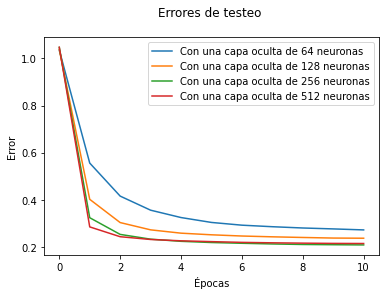

In [ ]:
fig, ax = plt.subplots()
ax.plot(test_losses64,label='Con una capa oculta de 64 neuronas')
ax.plot(test_losses128,label='Con una capa oculta de 128 neuronas')
ax.plot(test_losses256,label='Con una capa oculta de 256 neuronas')
ax.plot(test_losses512, label='Con una capa oculta de 512 neuronas')
ax.set_title("Errores de testeo \n")
ax.set_xlabel('Épocas')  
ax.set_ylabel('Error')
ax.legend()

In [ ]:
from scipy.special import expit

In [ ]:
number = 4

Text(0.5, 1.0, 'Número obtenido del dataset MNIST')

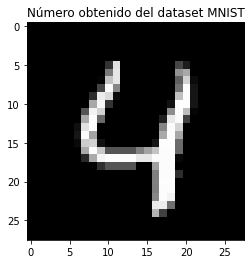

In [ ]:
plt.imshow(flatten(mnist_test[number][0]).reshape([28,28]), cmap='gray')
plt.title("Número obtenido del dataset MNIST")


Text(0.5, 1.0, 'Número replicado por medio del autoencoder y \n usando como optimization function la función ADAM')

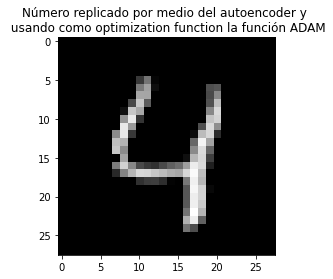

In [ ]:
plt.imshow(autoenc(flatten(mnist_test[number][0]).unsqueeze(0)).detach().numpy().reshape([28,28]), cmap = 'gray')
plt.title("Número replicado por medio del autoencoder y \n usando como optimization function la función ADAM")


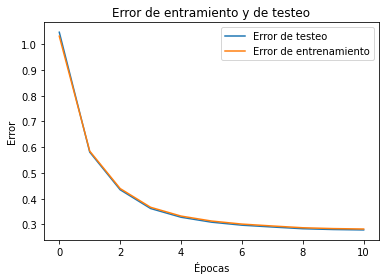

In [ ]:
fig, ax = plt.subplots()
ax.plot(test_losses, label='Error de testeo')
ax.plot(train_losses, label='Error de entrenamiento')
ax.set_title("Error de entramiento y de testeo")
ax.set_xlabel('Épocas')  
ax.set_ylabel('Error')
ax.legend()